### 자전거 대여 수요 예측 경진대회

날짜, 계절, 근무일 여부, 날씨, 온도, 체감 온도, 풍속 데이터를 활용하여 자전거 대여 수량 예측
- 문제 유형 : 회귀
- 평가 지표 : RMSLE
- 데이터 크기 : 1.1MB
- 제출 시 사용한 모델 : RandomForestRegressor

In [2]:
import pandas as pd, numpy as np

train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
sub_data = pd.read_csv("./data/sampleSubmission.csv")

print(train_data.shape, test_data.shape)
print(train_data.isna().sum().sum()) # 결측치 : 0

(10886, 12) (6493, 9)
0


|feature name|explanation|
|---|---|
|datetime|기록 일시(1시간 간격)|
|season|계절(1:봄, 2:여름, 3:가을, 4:겨울)|
|holiday|공휴일 여부(0:공휴일 아님, 1:공휴일)|
|workingday|근무일 여부(0:근무일 아님, 1:근무일) <br> *주말과 공휴일이 아니면 근무일이라고 간주|
|weather|날씨(1:맑음, 2:옅은 안개, 약간 흐림 <br> 3:약간의 눈, 약간의 비와 천둥 번개, 흐림 <br> 4: 폭우와 천둥번개, 눈과 짙은 안개 <br> * 숫자가 클수록 날씨가 안좋음)|
|temp|실제 온도|
|atemp|체감 온도|
|humidity|상대 습도|
|windspeed|풍속|
|casual|등록되지 않은 사용자(비회원) 수|
|registered|등록된 사용자(회원) 수|
|count|자전거 대여 수량|

In [3]:
train_data.head()

# datetime ~ registered : 예측에 사용할 수 있는 features.
# count : 예측해야 할 target값
# datetime의 경우 한 시간 간격으로 기록되어 있다.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test_data.head()

# 마찬가지로 windspeed까지의 feature를 사용해서 count값을 예측해야 하지만, 테스트 데이터에 casual과 registered feature는 없기 때문에 제외하고 진행.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### 데이터 분석 결과

datetime ~ registered까지는 예측에 사용할 수 있는 features이고, count는 예측해야 할 target값이며, datetime의 경우 한 시간 간격으로 기록되어 있다. 다만, test_data의 features를 살펴보면 casual과 registered라는 feature가 없기 때문에 train_data에서도 casual과 registered를 제외하고 모델을 훈련한다.


### 샘플 제출 파일 살펴보기

In [5]:
sub_data.head()

# 데이터를 구분하는 ID(datetime)값과 타겟값으로 구성되어 있다. 현재는 타겟값이 모두 0인데, 시간대별 대여 수량을 예측해 이 값들을 변경하여 제출한다.

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [6]:
# info()함수를 사용하여 결측치, 데이터 타입을 확인한다.
train_data.info()

# 결측치의 개수는 없는 것으로 확인된다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
test_data.info()

# 테스트 데이터에도 결측치는 존재하지 않으며, Date type또한 동일하기 때문에 예측을 진행한다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### Feature Engineering - 데이터 시각화

데이터를 시각화 하기에 앞서, 수치형 변수가 아닌 datetime에 대한 작업을 진행하다.

In [8]:
# datetime의 type은 object이다. python의 string과 비슷하다고 볼 수 있다. 
# datetime은 연도, 월, 일, 시간, 분, 초로 구성되어 있다.

print(train_data['datetime'][100])
print(train_data['datetime'][100].split())
print(train_data['datetime'][100].split()[0]) # 날짜
print(train_data['datetime'][100].split()[0].split('-')) # 날짜를 -를 기준으로 나눠
print(train_data['datetime'][100].split()[0].split('-')[0]) # 연도
print(train_data['datetime'][100].split()[0].split('-')[1]) # 월
print(train_data['datetime'][100].split()[0].split('-')[2]) # 일을 얻을 수 있다.
print(train_data['datetime'][100].split()[1]) # 시간
print(train_data['datetime'][100].split()[1].split(':')) # 시간을 :를 기준으로 나눠
print(train_data['datetime'][100].split()[1].split(':')[0]) # 시
print(train_data['datetime'][100].split()[1].split(':')[1]) # 분
print(train_data['datetime'][100].split()[1].split(':')[2]) # 초를 얻을 수 있다.

2011-01-05 09:00:00
['2011-01-05', '09:00:00']
2011-01-05
['2011', '01', '05']
2011
01
05
09:00:00
['09', '00', '00']
09
00
00


In [9]:
# 다음으로는 apply()함수를 이용해 파생 피처를 생성한다.
train_data['date'] = train_data['datetime'].apply(lambda x : x.split()[0]) # 날짜 피쳐 생성

# 연도, 월, 일, 시, 분, 초 피처를 차례로 생성
train_data['year'] = train_data['datetime'].apply(lambda x : x.split()[0].split('-')[0])
train_data['month'] = train_data['datetime'].apply(lambda x : x.split()[0].split('-')[1])
train_data['day'] = train_data['datetime'].apply(lambda x : x.split()[0].split('-')[2])
train_data['hour'] = train_data['datetime'].apply(lambda x : x.split()[1].split(':')[0])
train_data['minute'] = train_data['datetime'].apply(lambda x : x.split()[1].split(':')[1])
train_data['second'] = train_data['datetime'].apply(lambda x : x.split()[1].split(':')[2])

In [10]:
train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011-01-01,2011,01,01,00,00,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011-01-01,2011,01,01,01,00,00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011-01-01,2011,01,01,02,00,00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011-01-01,2011,01,01,03,00,00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011-01-01,2011,01,01,04,00,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012-12-19,2012,12,19,19,00,00
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012-12-19,2012,12,19,20,00,00
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012-12-19,2012,12,19,21,00,00
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012-12-19,2012,12,19,22,00,00


In [11]:
# 요일 피처를 생성한다. 요일 피처의 경우 calendar와 datetime 라이브러리를 활용해 만들 수 있다.

from datetime import datetime
import calendar

print(train_data['date'][100])
print(datetime.strptime(train_data['date'][100], "%Y-%m-%d")) # datetime 타입으로 변경
# 정수로 요일 변환
print(datetime.strptime(train_data['date'][100], "%Y-%m-%d").weekday()) # weekday() : 요일 반환 메소드
# 문자열로 요일 변환
print(calendar.day_name[datetime.strptime(train_data['date'][100], "%Y-%m-%d").weekday()]) # 0~6의 인덱스에 각 요일 이름이 매핑되어 있음. 2 : 수요일

2011-01-05
2011-01-05 00:00:00
2
Wednesday


In [12]:
# 요일 피처를 추가한다.
train_data['weekday'] = train_data['date'].apply(lambda dateString : calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


In [13]:
# season과 weather 피처의 경우 1, 2, 3, 4라는 정수로만 표시되어 있어 정확한 의미 파악이 어렵다. 시각화 시 의미가 잘 드러나도록 map()함수를 이용해 문자열로 바꾼다.

train_data['season'] = train_data['season'].map({1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter"})
train_data['weather'] = train_data['weather'].map({1:"Clear", 2:"Mist, Few Clouds", 3:"Light Snow, Train, ThunderStorms", 4:"Heavy Rain, ThunderStorms, Snow, Fog"})

train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0000,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0000,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0000,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0000,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0000,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,Winter,0,1,Clear,15.58,19.695,50,26.0027,7,329,336,2012-12-19,2012,12,19,19,00,00,Wednesday
10882,2012-12-19 20:00:00,Winter,0,1,Clear,14.76,17.425,57,15.0013,10,231,241,2012-12-19,2012,12,19,20,00,00,Wednesday
10883,2012-12-19 21:00:00,Winter,0,1,Clear,13.94,15.910,61,15.0013,4,164,168,2012-12-19,2012,12,19,21,00,00,Wednesday
10884,2012-12-19 22:00:00,Winter,0,1,Clear,13.94,17.425,61,6.0032,12,117,129,2012-12-19,2012,12,19,22,00,00,Wednesday


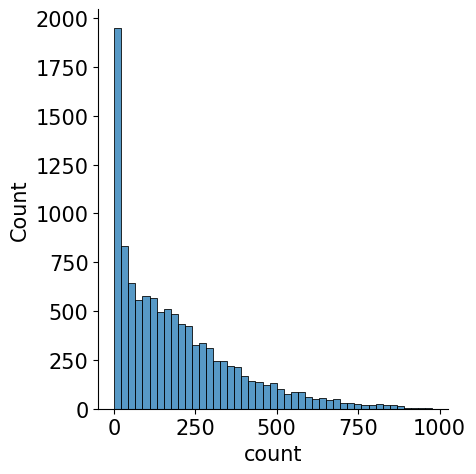

In [14]:
# date feature가 제공하는 정보는 모두 year, month, day feature에도 있어서 추후 date 피처는 제거한다.
# 또한 세 달씩 "월"을 묶으면 계절이 된다. 세분화된 month 피처를 세 달씩 묶으면 season피처와 의미가 같아진다. month를 제거한다.

# 그래프 시각화
import seaborn as sns, matplotlib as mlp, matplotlib.pyplot as plt
%matplotlib inline

# 타겟값의 분포도(수치형 데이터의 집계 값을 나타내는 그래프. 집계값 : 총 개수 or 비율)를 그려본다. 타겟값의 분포를 알면 훈련 시 타겟값을 그대로 사용할지 변환해 사용할지 파악할 수 있다.
mlp.rc("font", size=15) # fontsize 조절
sns.displot(train_data['count']) # 분포도 출력

# x축은 타겟값은 count를 나타내고, y축은 그 총 개수를 나타낸다. 분포도를 살펴보면 count가 0 근처에 몰려있다. 분포가 왼쪽으로 많이 편향되어 있다는 것이다.
# 회귀 모델이 좋은 성능을 내려면 정규 분포를 따라야 하는데, 현재 타겟값 count의 경우 그 분포를 따르지 않는다.
# 데이터 분포를 정규 분포에 가깝게 만들기 위해 가장 많이 사용하는 방법은 로그 변환이다. 로그 변환은 아래 분포와 같이 왼쪽으로 편향되어 있을때 자주 사용한다.

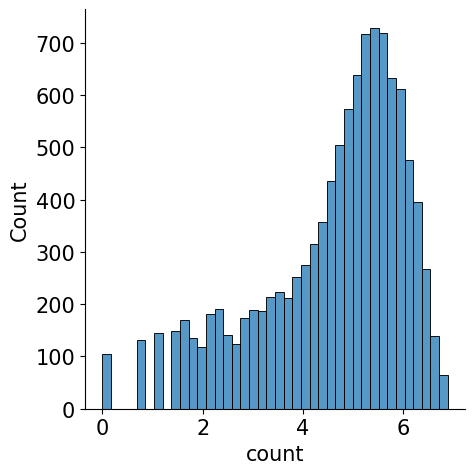

In [15]:
# 로그 변환
sns.displot(np.log(train_data['count']))
# 로그 변환하되, 마지막엔 지수 변환을 해서 실제 타겟값으로 복원해야 한다. 

### 범주형 변수 중요도 파악하기

각 범주형 데이터에 따라 평균 대여 수량이 어떻게 다른지 파악하기 위해 시각화를 하게 되면, 어떤 피처가 중요한지 알 수 있게 된다. 이 때 막대 그래프를 사용하며 `seaborn`패키지의 `barplot()`함수를 사용한다

### Bar subplots로 데이터 확인하기

|그래프 번호|설명|
|---|---|
|1|연도별 평균 대여 수량 그래프를 보면 2011년보다 2012년이 더 많음을 알 수 있다.|
|2|월별 평균 대여 수량의 추세를 파악할 수 있다. 평균 대여 수량은 6월에 가장 많고 1월에 가장 적다. <br>날씨가 따뜻할수록 대여 수량이 많음을 짐작할 수 있다.|
|3|일별 평균 대여 수량 그래프이다. train_data에는 1~19일까지의 데이터만 있고, 20일부터 나머지 데이터는 test_data에 있다. <br> 따라서 day column은 train_data와 test_data에서 공통된 값을 가지는게 아니기 때문에, 피처로 사용할 수 없다. |
|4|시간별 평균 대여 수량입니다. 새벽 4시에는 자전거를 타는 사람이 거의 없고, 아침 8시와 저녁 5~6시에 가장 많다고 할 수 있다. <br> 이 정보들을 미루어 보아 출 퇴근길에 가장 많이 이용한다고 생각할 수 있다.|
|5, 6|분별, 초별 평균 대여 수량 그래프는 아무 정보도 담고 있지 않기에, 모델 훈련 시 사용하지 않는다.|

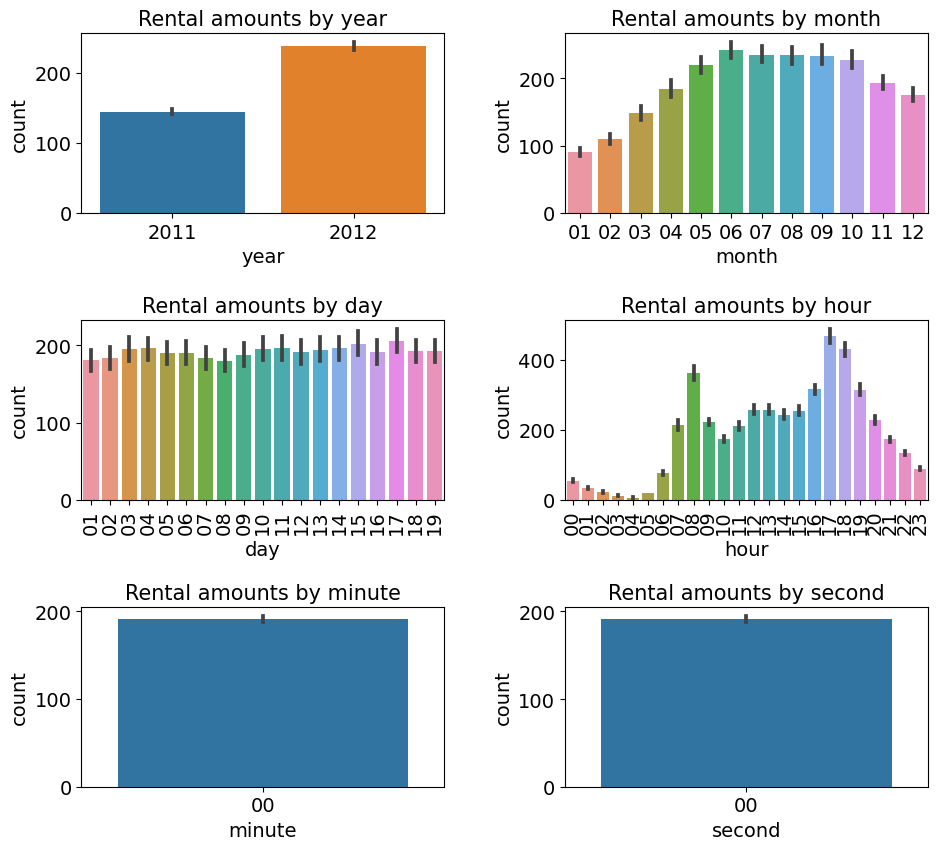

In [20]:
mlp.rc('font', size=14) # 폰트 크기 조절 
mlp.rc("axes", titlesize = 15) # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2) # 3행 2열의 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(10, 9) # 전체 Figure 크기를 10x9 인치로 설정

# 각축에 각 데이터의 서브플롯을 할당한다.
sns.barplot(x='year', y='count', data=train_data, ax=axes[0, 0])
sns.barplot(x='month', y='count', data=train_data, ax=axes[0, 1])
sns.barplot(x='day', y='count', data=train_data, ax=axes[1, 0])
sns.barplot(x='hour', y='count', data=train_data, ax=axes[1, 1])
sns.barplot(x='minute', y='count', data=train_data, ax=axes[2, 0])
sns.barplot(x='second', y='count', data=train_data, ax=axes[2, 1])

# 각 서브플롯에 제목달기
axes[0, 0].set(title="Rental amounts by year")
axes[0, 1].set(title="Rental amounts by month")
axes[1, 0].set(title="Rental amounts by day")
axes[1, 1].set(title="Rental amounts by hour")
axes[2, 0].set(title="Rental amounts by minute")
axes[2, 1].set(title="Rental amounts by second")

# 1행에 위치한 서브플롯들의 x축 회전
axes[1, 0].tick_params(axis='x', labelrotation=90)
axes[1, 1].tick_params(axis='x', labelrotation=90)

### Box subplots로 데이터 확인하기

|그래프 번호|설명|
|---|---|
|1|자전거 대여 수량은 봄에 가장 적고, 가을에 가장 많다.|
|2|날씨가 좋을 때 수량이 가장 많고, 안 좋을수록 수량이 적다. 폭우 폭설 시에는 거의 수량이 없다.|
|3|공휴일 여부에 따른 대여 수량을 나타내는 박스플롯. x축 라벨 0은 공휴일이 아니라는 뜻이고, 1은 공휴일이라는 뜻이다. <br> 공휴일일 때와 아닐 때 자전거 대여 수량의 중앙값은 거의 비슷하다. 다만, 공휴일이 아닐 때는 이상치가 많다.|
|4|근무일 여부에 따른 대여 수량을 나타내는데, 근무일일 때 이상치가 많다. 근무일은 공휴일과 주말을 제외한 나머지 날을 뜻한다.|

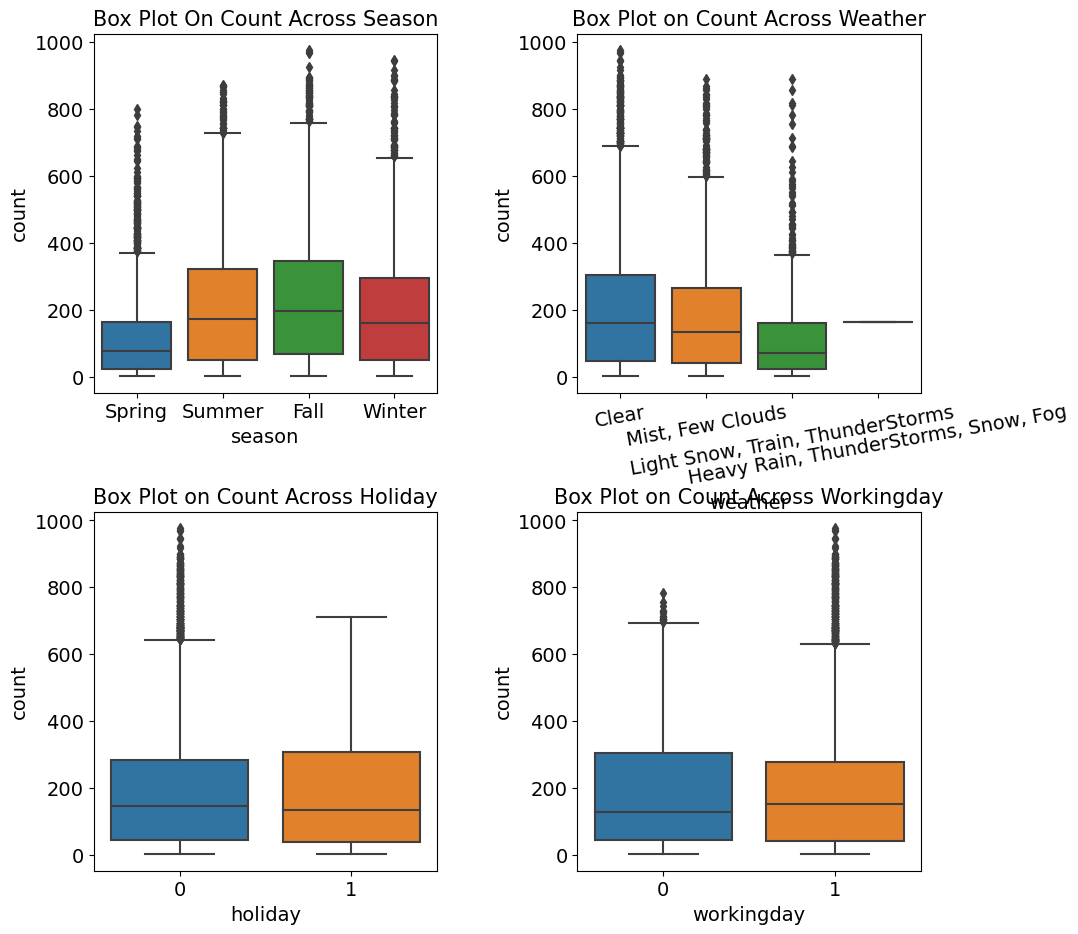

In [19]:
figure, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
figure.set_size_inches(10, 10)

# 서브 플롯 할당
sns.boxplot(x='season', y='count', data=train_data, ax=axes[0, 0])
sns.boxplot(x='weather', y='count', data=train_data, ax=axes[0, 1])
sns.boxplot(x='holiday', y='count', data=train_data, ax=axes[1, 0])
sns.boxplot(x='workingday', y='count', data=train_data, ax=axes[1, 1])

# 서브플롯 제목달기
axes[0, 0].set(title="Box Plot On Count Across Season")
axes[0, 1].set(title="Box Plot On Count Across Weather")
axes[1, 0].set(title="Box Plot On Count Across Holiday")
axes[1, 1].set(title="Box Plot On Count Across Workingday")

# 라벨 겹치는 현상 해결
axes[0, 1].tick_params(axis='x', labelrotation = 10)
axes[0, 1].set(title="Box Plot on Count Across Weather")
axes[1, 0].set(title="Box Plot on Count Across Holiday")
axes[1, 1].set(title="Box Plot on Count Across Workingday")

# x축 라벨 겹침 해결
axes[0, 1].tick_params(axis='x', labelrotation=10)

### Point Plot
포인트 플롯은 범주형 데이터에 따른 수치형 데이터의 평균과 신뢰구간을 점과 선으로 표시합니다. 막대 그래프와 동일한 정보를 제공하지만, 한 화면에 여러 그래프를 두고 비교해보기에 적합합니다.

<AxesSubplot: xlabel='hour', ylabel='count'>

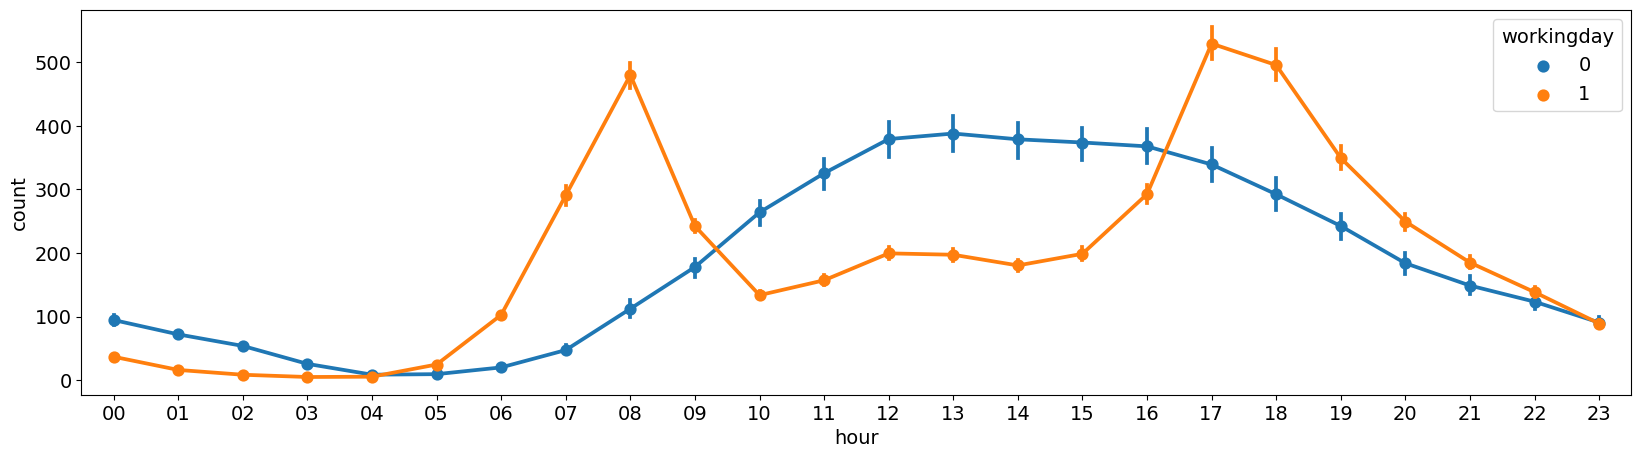

In [26]:
# 근무일에 따른 시간대별 평균 대여 수량
# 점은 평균값을 의미하며, 선은 데이터의 분포를 의미한다.
# 출근시간인 7~8시, 퇴근시간인 17~18시가 이용량이 많은것을 알 수 있다.
plt.figure(figsize=(20, 5))
sns.pointplot(data=train_data, x='hour', y='count', hue=train_data['workingday'])

<AxesSubplot: xlabel='hour', ylabel='count'>

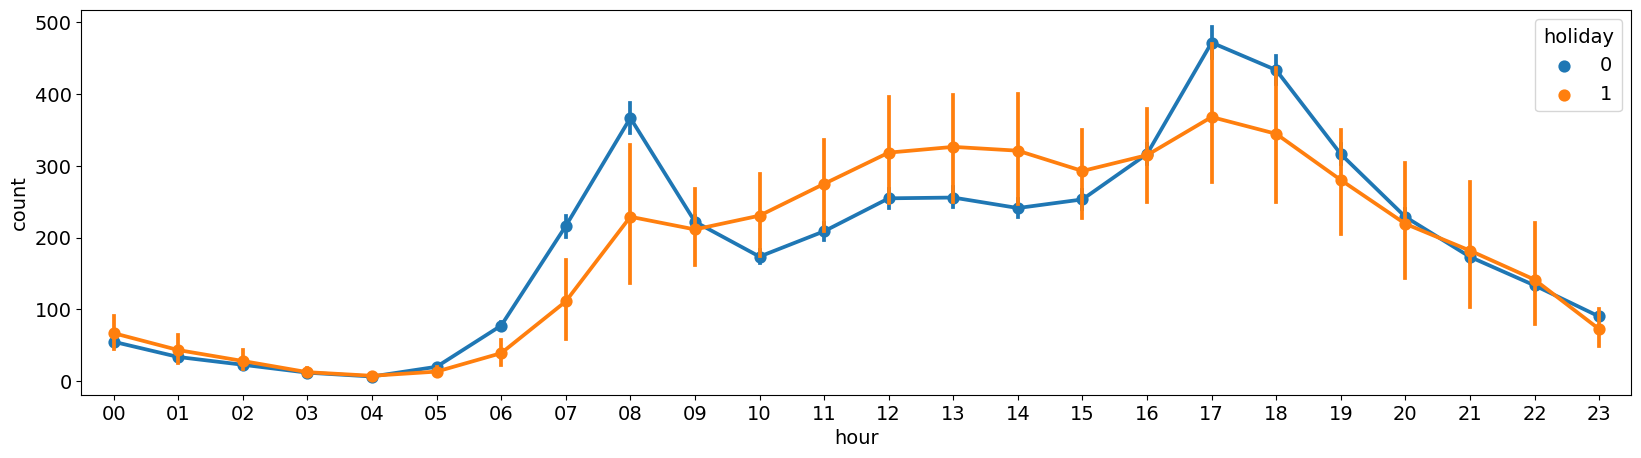

In [27]:
# 휴일에 따른 평균 대여 수량
plt.figure(figsize=(20, 5))
sns.pointplot(data=train_data, x='hour', y='count', hue=train_data['holiday'])

<AxesSubplot: xlabel='hour', ylabel='count'>

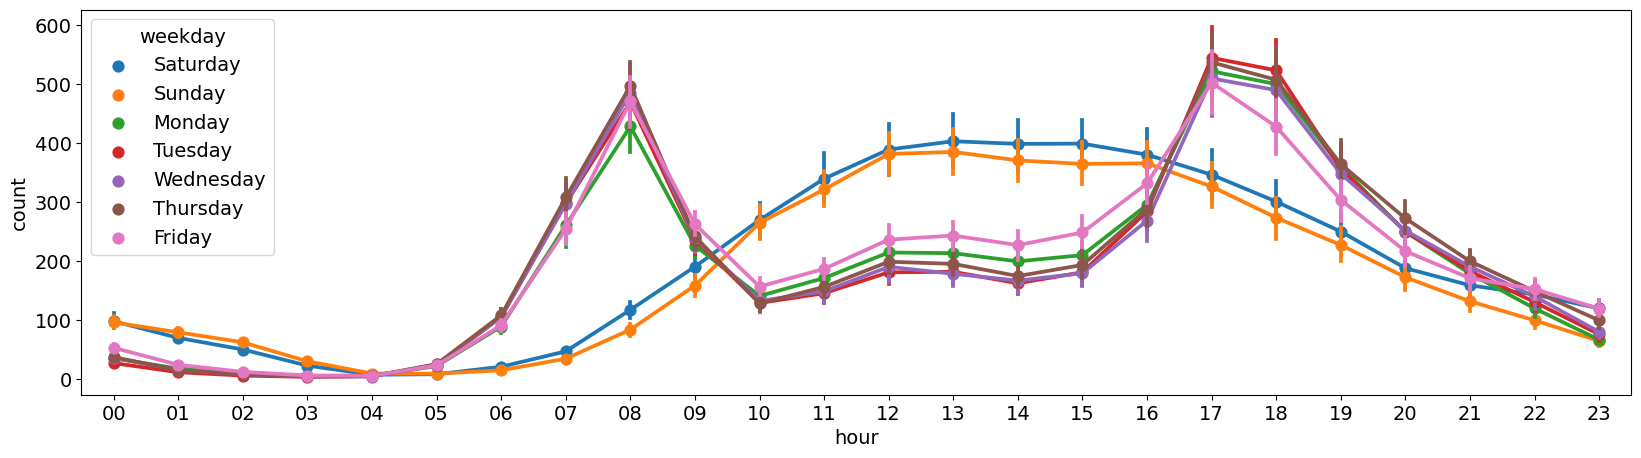

In [28]:
# 요일에 따른 평균 대여 수량
plt.figure(figsize=(20, 5))
sns.pointplot(data=train_data, x='hour', y='count', hue=train_data['weekday'])

<AxesSubplot: xlabel='hour', ylabel='count'>

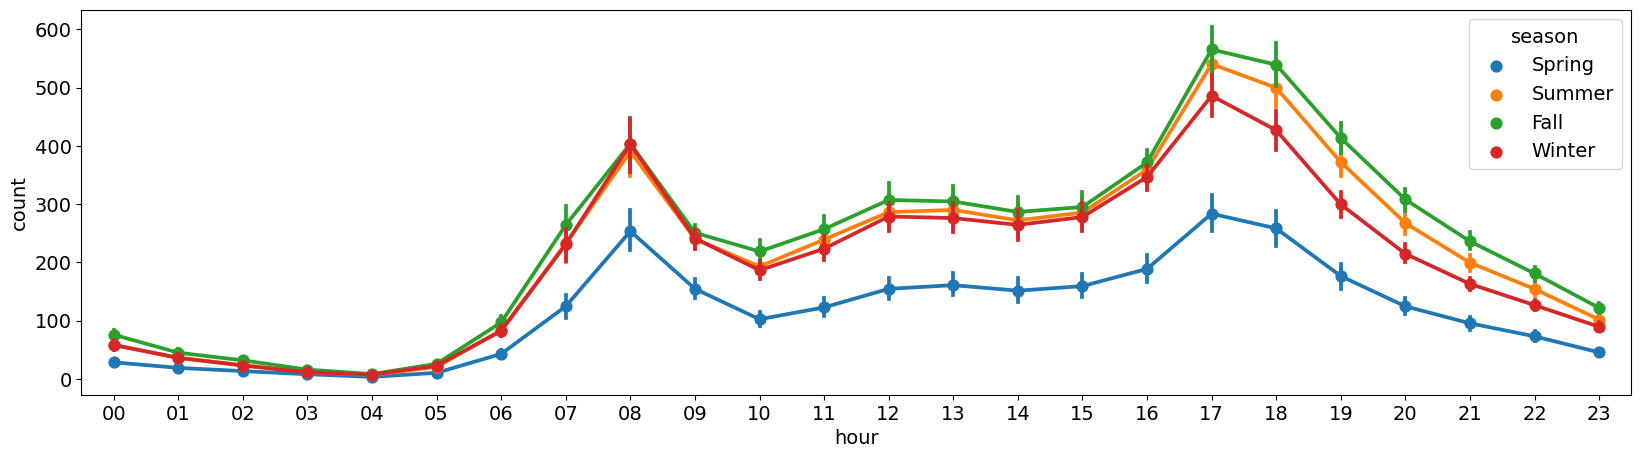

In [29]:
# 계절에 따른 평균 이용량
# 가을, 여름, 겨울, 봄 순으로 높은것을 확인할 수 있다.
plt.figure(figsize=(20, 5))
sns.pointplot(data=train_data, x='hour', y='count', hue=train_data['season'])

<AxesSubplot: xlabel='hour', ylabel='count'>

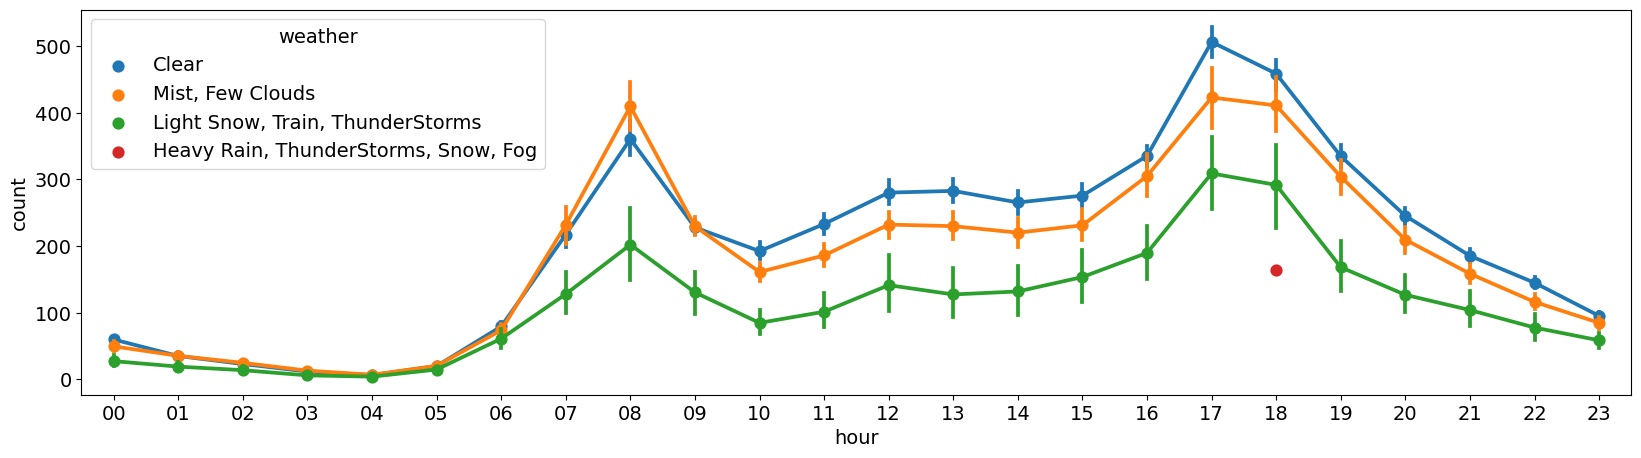

In [30]:
# 날씨에 따른 평균 대여 이용량
# 날씨가 좋을 때 평균적으로 많이 이용하는 편이나, 빨간 점은 누군가 정말 급한 일이 생겨 폭우, 뇌우를 뚫고 빌린 것을 확인할 수 있다.
# 이러한 이상치는 제거하는것도 고려해야 한다.
plt.figure(figsize=(20, 5))
sns.pointplot(data=train_data, x='hour', y='count', hue=train_data['weather'])

### 회귀선을 포함하는 산점도 그래프
수치형 데이터인 온도, 체감온도, 습도별 대여 수량을 회귀선을 포함한 산점도 그래프로 시각화한다. 회귀선은 각 수치형 데이터 간의 상관관계를 분석하는데 이용한다.

회귀선의 기울기를 통해 대략적인 추세를 파악한다.

|그래프 번호|설명|
|---|---|
|1, 2|온도와 체감 온도가 높을 수록 대여 수량이 많다.|
|3|회귀선을 보면 풍속이 셀수록 대여 수량이 많다. windspeed 컬럼 내에 풍속이 0으로 측정된 데이터가 꽤나 많기 때문이다. <br> 이런 경우 관측치가 없거나, 오류로 인해 0으로 기록되었을 확률이 높다. 결측값이 많아 그래프만으로 풍속과 대여 수량의 상관관계를 파악하기에는 어려움이 있다. <br> 이런 경우 결측값을 다른 값으로 대체하거나, 컬럼을 삭제하여 훈련때 사용하지 않는데, 이번에는 컬럼을 삭제하여 모델 훈련에 사용하지 않는다.|
|4|습도는 낮을수록 대여를 많이 한다. 수량은 추울때보다 따듯할때 많고, 습할때보다 습하지 않을 때 많다.|

<AxesSubplot: xlabel='humidity', ylabel='count'>

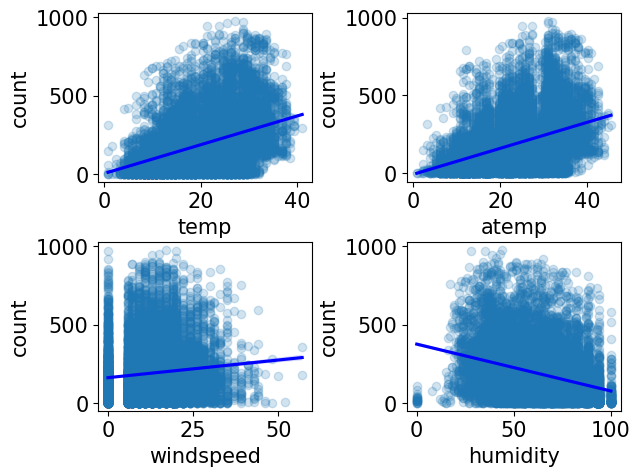

In [31]:
mlp.rc('font', size=15)
figure, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()

# 온도, 체감온도, 풍속, 습도 별 대여 수량 산점도 그래프
# scatter_kws 속성 : 산점도 그래프에 직히는 점의 투명도를 조절합니다.
# line_kws 속성 : 회귀선의 색상을 선택하는 파라미터.
sns.regplot(x='temp', y='count', data=train_data, ax=axes[0, 0], scatter_kws={"alpha":0.2}, line_kws={"color":"blue"})
sns.regplot(x='atemp', y='count', data=train_data, ax=axes[0, 1], scatter_kws={"alpha":0.2}, line_kws={"color":"blue"})
sns.regplot(x='windspeed', y='count', data=train_data, ax=axes[1, 0], scatter_kws={"alpha":0.2}, line_kws={"color":"blue"})
sns.regplot(x='humidity', y='count', data=train_data, ax=axes[1, 1], scatter_kws={"alpha":0.2}, line_kws={"color":"blue"})

### 히트맵
현재 temp, atemp, humidity, windspeed, count는 수치형 데이터이다. 수치형 데이터끼리 상관관계를 확인하려면 dataframe에 corr()함수를 사용하면 된다.

In [32]:
train_data[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

# 이러한 방법도 좋지만, 보다 직관적으로 확인할 수 있는 상관관계 히트맵을 그릴 수 있다.

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


[Text(0.5, 1.0, 'HeatMap of Numerical Data')]

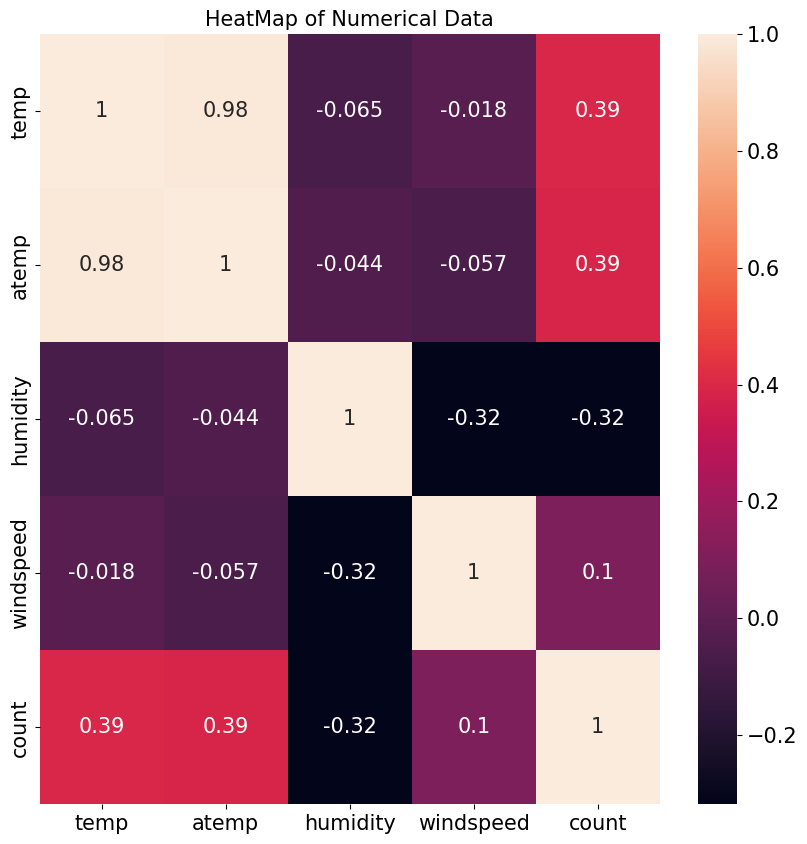

In [33]:
corrMat = train_data[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
figure, ax = plt.subplots()
figure.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True) # 상관관계 히트맵 그리기
ax.set(title="HeatMap of Numerical Data")

### 지금까지 행한 분석 정리 및 모델링 전략

1. 타겟값 변환 : 푼포도 확인 결과 타겟값인 count가 0 근처로 치우쳐 있었기 때문에 로그 변환하여 정규 분포에 가깝게 만들어야 했다. 타겟값을 count가 아닌 log(count)로 변환해 사용할 것이므로 마지막에 다시 지수 변환해 count로 복원했었다.
2. 파생 피쳐 추가 : datetime 피처는 여러 가지 정보의 혼합체이므로 각각을 분리해 year, month, day, hour, minute, second 피처를 생성할 수 있었다. 또한, datetime에 숨어있던 또 다른 정보인 요일 피처를 추가했었다.
3. 피처 제거
    - 테스트 데이터에 없는 피처인 casual과 registered가 있었다. train_data에는 없는 데이터이기 때문에 제거해서 사용할 예정이다.
    - datetime 피처는 인덱스 역할만 하기에 타겟값 예측에 의미가 없다.
    - date 피처가 제공하는 정보는 year, month, day 피처에 담겨있기에 의미가 없다.
    - month는 season 피처의 세부 분류로 볼 수 있다. 데이터가 지나치게 세분화 되어 있으면 분류별 데이터 수가 적어서 오히려 학습에 방해가 되기도 한다.
    - 막대 그래프 확인 결과 파생 피처인 day는 분별력이 없었고, minute와 second에는 아무런 정보가 담겨있지 않았다.
4. 이상치 제거 : 포인트 플롯 확인 결과 weather가 4인 데이터는 이상치이기에 제거 대상이다.
5. 피쳐 제거 : 산점도 그래프와 히트맵 확인 결과 windspeed 피처에는 결측값이 많고 대여 수량과의 상관관계가 매우 약했다.